### In this project i'm building a model based on 101 food class, My aim is to beat the accuracy of deep-food paper with the help of transfer learning.
* Here i am using efficientNetV2s model.
* used mixed precession training meathod.
* feature extraction Model


In [16]:
#checking the gpu
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c6a4db7c-8b41-58e7-fd06-74b4f2b4a071)


In [17]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [18]:
#importing our helperfunctions
!wget https://raw.githubusercontent.com/Hirann97/tensorflow_deeplearning/main/helper_function.py

--2022-11-24 11:50:52--  https://raw.githubusercontent.com/Hirann97/tensorflow_deeplearning/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10558 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.31K  --.-KB/s    in 0s      

2022-11-24 11:50:52 (71.3 MB/s) - ‘helper_function.py’ saved [10558/10558]



In [19]:
from helper_function import create_tensorboard_callback,create_tensorboard_callback,compare_historys,walk_through_dir

In [20]:
import tensorflow_datasets as tfds
 
food_101_info = tfds.builder(name='food101').info
print(food_101_info.download_size)

4.65 GiB


In [21]:
(train_data,test_data),ds_info=tfds.load(name='food101',
                                         split=['train','validation'],
                                         shuffle_files=False,
                                         as_supervised=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteHKNYNL/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteHKNYNL/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [22]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [23]:
class_names=ds_info.features['label'].names

In [24]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Exploring tha data sets.


In [25]:
# taking one sample of the dataset
train_one_sample=train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
#lets find some info image tensor and lable by using a loop
for image,label in train_one_sample:
  print(f"""
  image shape:{image.shape}
  image dtypw: {image.dtype}
  Target class from Food101 (tensor form): {label}
  class_name in(str form):{class_names[label.numpy()]}
  """)


  image shape:(512, 512, 3)
  image dtypw: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  class_name in(str form):huevos_rancheros
  


In [27]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

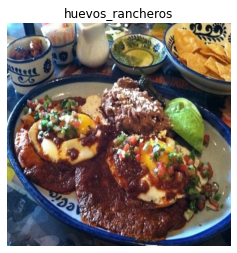

In [28]:
# ploting a random image tensor

import matplotlib.pyplot as plt
plt.figure(figsize=(4,6))
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);


# creating preprocessing functions:

In [29]:
def preprocess_img(image,label,img_shape=224):
  image=tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

In [30]:
preprocessed_img=preprocess_img(image,label)[0]

In [31]:
print(f"""
image before preprocessing: {image[:2]}
image_shape before preprocessing: {image.shape}
d type: {image.dtype}
image after preprocessing: {preprocessed_img[:2]}
image shape after preprocessing: {preprocessed_img.shape}
d type after preprocessing: {preprocessed_img.dtype}
""")


image before preprocessing: [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]
image_shape before preprocessing: (512, 512, 3)
d type: <dtype: 'uint8'>
image after preprocessing: [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]
image shape after preprocessing: (224, 224, 3)
d type after preprocessing: <dtype: 'float32'>



(-0.5, 223.5, 223.5, -0.5)

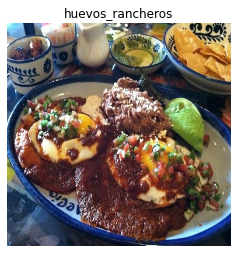

In [32]:
# ploting a  image tensor after preprocessing

import matplotlib.pyplot as plt
plt.figure(figsize=(4,6))
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)



In [33]:
# map preprocessing function to training data ( and parallelise it)
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data=train_data.shuffle(buffer_size=100).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

#map preprocessing function to test data 
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data=test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [34]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [35]:
# creating tensorboard_callbacks
# we had imported the callback function form the helper functions allready
checkpoint_path="model_checkpoint/cp.ckpt"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   moniter="val_accuracy",
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   verbose=0)

In [36]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

# Building a feature Extractor Model

In [37]:

from tensorflow.keras import layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetV2S(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,name='input_layer')
# as we are using the efficientnet model we dont need to rescale 
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x=layers.Dense(len(class_names))(x)

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

#model compiling
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

82420632/82420632 [==============================] - 5s 0us/step


In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                             

In [39]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-s False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [40]:
for layer in model.layers[1].layers[:30]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block1a_add False float32 <Policy "mixed_float16">
block1b_project_conv False float32 <Policy "mixed_float16">
block1b_project_bn False float32 <Policy "mixed_float16">
block1b_project_activation False float32 <Policy "mixed_float16">
block1b_drop False float32 <Policy "mixed_float16">
block1b_add False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float1

In [41]:
# fit the feature extraction model
history_101=model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=train_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name='training_logs',
                                                             experiment_name='efficientnetV2S 101 food class'),model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetV2S 101 food class/20221124-120129
Epoch 1/5
2368/2368 [==============================] - 225s 86ms/step - loss: 1.7660 - accuracy: 0.5626 - val_loss: 1.3771 - val_accuracy: 0.6441
Epoch 2/5
2368/2368 [==============================] - 200s 84ms/step - loss: 1.2895 - accuracy: 0.6655 - val_loss: 1.2079 - val_accuracy: 0.6886
Epoch 3/5
2368/2368 [==============================] - 201s 85ms/step - loss: 1.1584 - accuracy: 0.6964 - val_loss: 1.1128 - val_accuracy: 0.7137
Epoch 4/5
2368/2368 [==============================] - 199s 84ms/step - loss: 1.0748 - accuracy: 0.7177 - val_loss: 1.0418 - val_accuracy: 0.7307
Epoch 5/5
2368/2368 [==============================] - 200s 84ms/step - loss: 1.0120 - accuracy: 0.7328 - val_loss: 0.9941 - val_accuracy: 0.7421


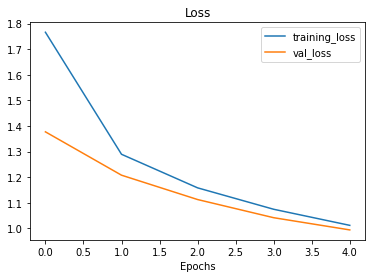

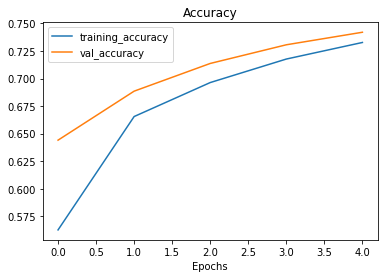

In [42]:
from helper_function import plot_loss_curves
plot_loss_curves(history_101)

In [43]:
# fine tuning the model - first 
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv False
37 bloc

In [44]:
model.save('/content/drive/MyDrive/tensorflow_models/food101_partial_mode')

loading the model from google drive for further use

In [45]:
model_2=tf.keras.models.load_model('/content/drive/MyDrive/tensorflow_models/food101_partial_mode')

In [46]:
model_2_results=model_2.evaluate(test_data)
model_2_results

790/790 [==============================] - 66s 79ms/step - loss: 1.0221 - accuracy: 0.7219


[1.0221136808395386, 0.7218613624572754]

In [47]:
# setting all the layers trainable
for layer in model_2.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-s True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [48]:
# checking
# Check the layers in the base model and see what dtype policy they're using
for layer in model_2.layers[1].layers[:50]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block1a_project_activation True float32 <Policy "mixed_float16">
block1a_add True float32 <Policy "mixed_float16">
block1b_project_conv True float32 <Policy "mixed_float16">
block1b_project_bn True float32 <Policy "mixed_float16">
block1b_project_activation True float32 <Policy "mixed_float16">
block1b_drop True float32 <Policy "mixed_float16">
block1b_add True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float16">
block2a_expand_activation True float32 <Policy "mixed_float16">
block2a_project_conv True float32 <Policy "mixed_float16">
block2a_projec

This training might take longer hours ,so it will be good to add some more callbacks like early stoping callbacks ,checkpoint and Reducelronplatue.

In [49]:
# early stpoing callbacks
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=3)

In [50]:
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [51]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [52]:
# compiling the model
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [53]:
# fiting the model
history_101_fine_tune=model_2.fit(train_data,
                                  epochs=100,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15*len(test_data)),
                                  callbacks=[create_tensorboard_callback("training_logs", "efficient2vs_101_classes_all_data_fine"),
                                             model_checkpoint,
                                             early_stopping,
                                             reduce_lr])

Saving TensorBoard log files to: training_logs/efficient2vs_101_classes_all_data_fine/20221124-122301
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.7638

2368/2368 [==============================] - 704s 284ms/step - loss: 0.8703 - accuracy: 0.7638 - val_loss: 0.6196 - val_accuracy: 0.8297 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 563s 237ms/step - loss: 0.3422 - accuracy: 0.9025 - val_loss: 0.7155 - val_accuracy: 0.8130 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9523
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 563s 237ms/step - loss: 0.1546 - accuracy: 0.9523 - val_loss: 0.7620 - val_accuracy: 0.8218 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 563s 237ms/step - loss: 0.0383 - accuracy: 0.9884 - val_loss: 0.7124 - val_accuracy: 0.8583 - lr: 2.0000e-05


In [54]:
model_2_fine_tune_results=model_2.evaluate(test_data)
model_2_fine_tune_results

790/790 [==============================] - 61s 77ms/step - loss: 0.7515 - accuracy: 0.8487


[0.7514693140983582, 0.8486732840538025]

In [55]:
#lets save this model
model_2.save('/content/drive/MyDrive/tensorflow_models/food_101_efficientnetv2s_fullmode')

In [56]:
loaded_model=tf.keras.models.load_model('/content/drive/MyDrive/tensorflow_models/food_101_efficientnetv2s_fullmode')

In [57]:
# Make predictions with model
pred_probs = loaded_model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 63s 75ms/step


In [58]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f'the class with highest prediction probability by the model for sample 0 is: {pred_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [7.62705898e-10 8.38805208e-14 3.80244144e-15 8.21098777e-13
 1.00814860e-11 3.30559191e-11 9.88354093e-14 3.55707516e-17
 5.24121302e-11 3.97176007e-11 1.26402185e-07 3.07284363e-16
 5.24277866e-09 3.27395666e-10 8.12017387e-09 9.14078044e-14
 9.04373337e-07 1.53724308e-11 9.42531032e-18 2.14647224e-12
 1.04548258e-16 1.14943832e-09 5.47378143e-08 8.08368834e-13
 8.50225076e-15 4.25980431e-13 1.03796615e-12 7.52349238e-10
 1.74454872e-14 9.99992013e-01 5.90701994e-08 1.41659739e-09
 1.79614628e-15 9.72450154e-18 5.35583577e-10 9.57945610e-14
 1.68124683e-13 4.86484876e-13 1.15481312e-17 3.92548771e-11
 6.62155936e-15 5.37037996e-18 3.76717581e-12 5.68418995e-17
 1.61927500e-16 1.02617977e-10 1.26184588e-12 3.50192769e-17
 1.44324409e-15 1.25655118e-14 1.07866972e-16 1.34040687e-13
 7.41358109e-17 1.08777917e-12 7.30963933e-20 1.12230895e-12
 2.37093819e-13 4.54408126e-12 2.03314943e-

In [59]:
pred_classes=pred_probs.argmax(axis=1)
pred_classes[:10]

array([29, 81, 91, 53, 97, 36, 10, 31,  3,  0])

In [60]:
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [61]:
print(y_labels[:10])
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


25250

In [62]:
from helper_function import load_and_prep_image,pred_and_plot

--2022-11-24 13:09:07--  https://images-gmi-pmc.edge-generalmills.com/9aaa5c61-860a-427f-a745-b5221f6b909e.jpg
Resolving images-gmi-pmc.edge-generalmills.com (images-gmi-pmc.edge-generalmills.com)... 152.195.60.25
Connecting to images-gmi-pmc.edge-generalmills.com (images-gmi-pmc.edge-generalmills.com)|152.195.60.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66164 (65K) [image/jpg]
Saving to: ‘9aaa5c61-860a-427f-a745-b5221f6b909e.jpg.2’

9aaa5c61-860a-427f- 100%[===================>]  64.61K  --.-KB/s    in 0.001s  

2022-11-24 13:09:07 (61.8 MB/s) - ‘9aaa5c61-860a-427f-a745-b5221f6b909e.jpg.2’ saved [66164/66164]

1/1 [==============================] - 3s 3s/step


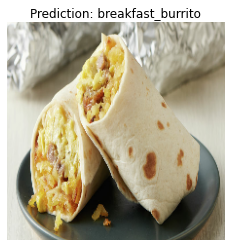

In [64]:
!wget https://images-gmi-pmc.edge-generalmills.com/9aaa5c61-860a-427f-a745-b5221f6b909e.jpg
pred_and_plot(model_2,'9aaa5c61-860a-427f-a745-b5221f6b909e.jpg',class_names)

--2022-11-24 13:10:52--  https://emilybites.com/wp-content/uploads/2021/06/Turkey-Sausage-Breakfast-Burritos-5b.jpg
Resolving emilybites.com (emilybites.com)... 151.101.130.159
Connecting to emilybites.com (emilybites.com)|151.101.130.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114842 (112K) [image/jpeg]
Saving to: ‘Turkey-Sausage-Breakfast-Burritos-5b.jpg’

Turkey-Sausage-Brea 100%[===================>] 112.15K  --.-KB/s    in 0.003s  

2022-11-24 13:10:52 (37.8 MB/s) - ‘Turkey-Sausage-Breakfast-Burritos-5b.jpg’ saved [114842/114842]

1/1 [==============================] - 0s 41ms/step


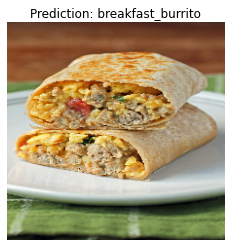

In [66]:
!wget https://emilybites.com/wp-content/uploads/2021/06/Turkey-Sausage-Breakfast-Burritos-5b.jpg
pred_and_plot(model_2,'Turkey-Sausage-Breakfast-Burritos-5b.jpg',class_names)


In [67]:
#Predict 100 images
import numpy as np
n=100
for img, label in test_data.unbatch():
  if n>=0:
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, dtype = tf.float32) 
    img = tf.expand_dims(img, axis =0)
    pred_prob = model_2.predict(img)
    pred = np.array(tf.argmax(pred_prob, axis = 1))
    pred_class=class_names[pred_prob.argmax()]
    print(label, pred)
    n=-1
    
  else:
    break  

1/1 [==============================] - 0s 75ms/step
tf.Tensor(29, shape=(), dtype=int64) [29]
